## Toy Sampling Animations 6 - DDIM

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll, ModelMixin
)
from torch.utils.data import Dataset
from tqdm import tqdm
from torch import nn
from pathlib import Path
# import cv2
from PIL import Image

from typing import Optional, Union, Tuple
from itertools import pairwise

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')
    plt.axis('equal')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [2]:
save_dir=Path('/home/stephen/sora/jun_26_1')
save_dir.mkdir(exist_ok=True)

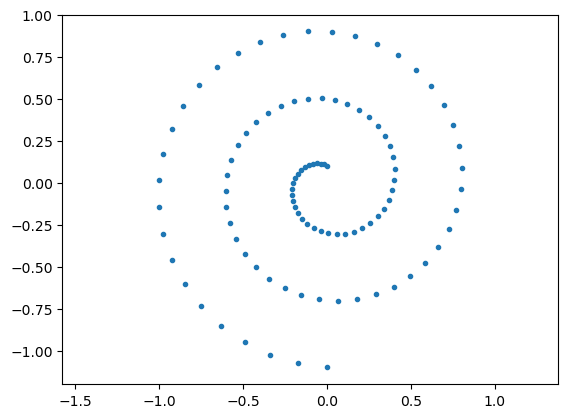

In [3]:
batch_size=2130
dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=batch_size)
plot_batch(next(iter(loader)))

In [4]:
schedule = ScheduleLogLinear(N=256, sigma_min=0.01, sigma_max=1) #N=200
# plt.plot(schedule.sigmas)

In [5]:
device='cpu' #Faster for toy model?
epochs=15000 #15000
lr=1e-3 #1e-3
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
# model = MLP(hidden_dims=(16,128,128,128,128,16)) #no time conditioning
model.to(device);
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_func=nn.MSELoss()

losses=[]
for _ in tqdm(range(epochs)):
    for x0 in loader:
        model.train()
        optimizer.zero_grad()
        
        eps = torch.randn_like(x0)
        sigma = schedule.sample_batch(x0)

        noised_data=x0 + sigma.unsqueeze(-1) * eps
        yhat=model(noised_data.to(device), sigma.to(device), cond=False) #lose usqueeze here for images?
        loss=loss_func(eps.to(device), yhat)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

100%|█████████████████████████████████████| 15000/15000 [00:50<00:00, 294.79it/s]


In [6]:
torch.save(model, '/home/stephen/sora/jun_26_2.pt')

In [7]:
bound=1.5
num_heatmap_steps=30
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

In [8]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

model.to(device);
gam=1
mu=0.00
cfg_scale=0.0
cond=None
sigmas=schedule.sample_sigmas(256)
xt_history=[]
heatmaps=[]

with torch.no_grad():
    model.eval();
    xt=torch.randn((batch_size,) + model.input_dims)*sigmas[0] #Scaling by sigma here matters a lot - why is that???

    for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
        eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
        # eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
        sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()
        xt = xt - (sig - sig_p) * eps + eta * model.rand_input(xt.shape[0]).to(xt)
        xt_history.append(xt.numpy())
        heatmaps.append(model.forward(grid, sig, cond=None))

xt_history=np.array(xt_history)

In [9]:
# plt.quiver(grid[:,0], grid[:,1], -heatmaps[-1][:,0], -heatmaps[-1][:,1], alpha=0.3, scale=35)

(-1.8, 1.8)

<Figure size 640x480 with 0 Axes>

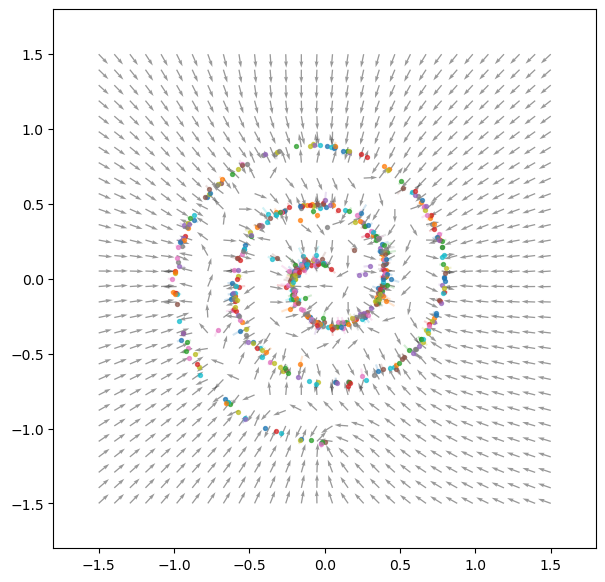

In [10]:
# for i in tqdm(range(len(heatmaps))):
i=255

plt.clf()
fig=plt.figure(0, (7,7))

heatmap_norm=torch.nn.functional.normalize(heatmaps[i], p=2, dim=1)
plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.4,  scale=40)

for j in range(512): #Just do a subset of trajetories
    plt.plot(xt_history[np.maximum(i-64, 0):i+1,j,0], xt_history[np.maximum(i-64, 0):i+1,j,1], '-', alpha=0.2)
    plt.scatter(xt_history[i,j,0], xt_history[i,j,1], alpha=0.7, s=8)

viz_bounds=1.8
plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
# plt.axis('square')
# plt.savefig(save_dir/(str(i)+'.png'))

In [11]:
heatmaps_np=np.array([h.numpy() for h in heatmaps])
np.save('/home/stephen/sora/ddim_heatmaps_2', heatmaps_np)
np.save('/home/stephen/sora/ddim_history_2', xt_history)

## Ok I think we do a fresh DDPM (noise and noiseless for comparison)

In [12]:
# # for i in tqdm(range(len(heatmaps))):
# i=255

# plt.clf()
# fig=plt.figure(0, (7,7))

# heatmap_norm=torch.nn.functional.normalize(heatmaps[i], p=2, dim=1)
# plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.4,  scale=40)

# for j in range(512): #Just do a subset of trajetories
#     plt.plot(xt_history[np.maximum(i-64, 0):i+1,j,0], xt_history[np.maximum(i-64, 0):i+1,j,1], '-', alpha=0.2)
#     plt.scatter(xt_history[i,j,0], xt_history[i,j,1], alpha=0.7, s=8)

# viz_bounds=1.8
# plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
# # plt.axis('square')
# # plt.savefig(save_dir/(str(i)+'.png'))

In [13]:
heatmaps[-1].shape

torch.Size([900, 2])

In [14]:
xt_history.shape

(256, 2130, 2)

In [15]:
# for i in tqdm(range(len(heatmaps))):
# # i=10

#     plt.clf()
#     fig=plt.figure(0, (7,7))
    
#     heatmap_norm=torch.nn.functional.normalize(heatmaps[i], p=2, dim=1)
#     plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.4,  scale=40)
    
#     for j in range(512): #Just do a subset of trajetories
#         plt.plot(xt_history[np.maximum(i-64, 0):i+1,j,0], xt_history[np.maximum(i-64, 0):i+1,j,1], '-', alpha=0.2)
#         plt.scatter(xt_history[i,j,0], xt_history[i,j,1], alpha=0.7, s=8)
    
#     viz_bounds=1.8
#     plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
#     # plt.axis('square')
#     plt.savefig(save_dir/(str(i)+'.png'))

In [16]:
np.maximum(i-64, 0)

191

In [17]:
len(dataset)

100

In [18]:
# for i in tqdm(range(len(heatmaps))):
#     plt.clf()
#     fig=plt.figure(0, (7,7))
#     heatmap_norm=torch.nn.functional.normalize(heatmaps[i], p=2, dim=1)
#     plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.5,  scale=40)
#     plt.axis('square')
#     plt.savefig(save_dir/(str(i)+'.png'))

In [19]:
# for i in range(512): #Just do a subset of trajetories
#     plt.plot(xt_history[:,i,0], xt_history[:,i,1], '-', alpha=0.1)

# plt.scatter(xt_history[-1,:,0], xt_history[-1,:,1], alpha=0.6, s=5)
# plt.xlim([-1.1, 1.1]);  plt.ylim([-1.1, 1.1])